In [1]:
# Import required libraries
import numpy as np
import pandas as pd
np.random.seed(8)
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from keras.models import Model
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D
from keras.preprocessing import text, sequence
from keras.callbacks import Callback

import re
import warnings
warnings.filterwarnings('ignore')

# Read in train and test datasets from csv files
train = pd.read_csv('train.csv')
test_cm = pd.read_csv('test.csv')
test_lb = pd.read_csv('test_labels.csv')
# Merge test comments with test labels
test_all = pd.merge(test_cm, test_lb, on='id')
# Remove all test entries with labels equal to -1
test = test_all[test_all['toxic'] != -1]

Using TensorFlow backend.


In [2]:
label_names = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
X_train = train["comment_text"]
y_train = train[label_names].values
X_test = test["comment_text"]
y_test = test[label_names].values

In [3]:
# Define vocabulary size
vocab = 100000
# Define maximum length of a comment
maxlen = 200
# Define embedding size which should equal the embedding size of the pre-trained word vectors
embed_size = 300

In [4]:
'''# Removing ip address
X_train = X_train.apply(lambda x: re.sub("(?:[0-9]{1,3}\.){3}[0-9]{1,3}","",x))
X_test = X_test.apply(lambda x: re.sub("(?:[0-9]{1,3}\.){3}[0-9]{1,3}","",x))
# Removing url link
X_train = X_train.apply(lambda x: re.sub("http://.*com","",x))
X_test = X_test.apply(lambda x: re.sub("http://.*com","",x))
# Removing username
X_train = X_train.apply(lambda x: re.sub("\[\[.*\]","",x))
X_test = X_test.apply(lambda x: re.sub("\[\[.*\]","",x))'''

'# Removing ip address\nX_train = X_train.apply(lambda x: re.sub("(?:[0-9]{1,3}\\.){3}[0-9]{1,3}","",x))\nX_test = X_test.apply(lambda x: re.sub("(?:[0-9]{1,3}\\.){3}[0-9]{1,3}","",x))\n# Removing url link\nX_train = X_train.apply(lambda x: re.sub("http://.*com","",x))\nX_test = X_test.apply(lambda x: re.sub("http://.*com","",x))\n# Removing username\nX_train = X_train.apply(lambda x: re.sub("\\[\\[.*\\]","",x))\nX_test = X_test.apply(lambda x: re.sub("\\[\\[.*\\]","",x))'

In [5]:
'''# Filter out stop words
from nltk.corpus import stopwords

def filter_stop_words(sentences, stop_words):
    filtered = []
    for sentence in sentences:
        words = sentence.split()
        words_filtered = [word for word in words if word not in stop_words]
        filtered.append(" ".join(words_filtered))
    return filtered
 
stop_words = set(stopwords.words("english"))
 
# Comments in train
X_train_ = filter_stop_words(X_train, stop_words)
 
# Comments in test (excluding labels with -1 values)
X_test_ = filter_stop_words(X_test, stop_words)'''

'# Filter out stop words\nfrom nltk.corpus import stopwords\n\ndef filter_stop_words(sentences, stop_words):\n    filtered = []\n    for sentence in sentences:\n        words = sentence.split()\n        words_filtered = [word for word in words if word not in stop_words]\n        filtered.append(" ".join(words_filtered))\n    return filtered\n \nstop_words = set(stopwords.words("english"))\n \n# Comments in train\nX_train_ = filter_stop_words(X_train, stop_words)\n \n# Comments in test (excluding labels with -1 values)\nX_test_ = filter_stop_words(X_test, stop_words)'

In [6]:
# Tokenize the train dataset
t = text.Tokenizer(num_words=vocab)
t.fit_on_texts(list(X_train))

In [7]:
# Convert both train and test datasets into sequences
X_train = t.texts_to_sequences(X_train)
X_test = t.texts_to_sequences(X_test)
x_train = sequence.pad_sequences(X_train, maxlen=maxlen)
x_test = sequence.pad_sequences(X_test, maxlen=maxlen)

In [8]:
# Load pre-trained word vectors
EMBEDDING_FILE = 'crawl-300d-2M.vec'
embeddings_index = dict()
f = open(EMBEDDING_FILE)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s pre-trained words' % len(embeddings_index))

Loaded 2000000 pre-trained words


In [9]:
# Create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab, embed_size))
for word, i in t.word_index.items():
    if i >= vocab: 
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [10]:
# Define make_model function to create a CNN model
def make_model(k=[7], activation='relu', filters=100, Sdroprate=0.5, droprate=0.0):

    inp = Input(shape=(maxlen, ))
    x = Embedding(vocab, embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False)(inp)
    x = SpatialDropout1D(Sdroprate)(x)
    x = Reshape((maxlen, embed_size, 1))(x)
    
    conv = dict()
    maxpool = dict()
    for h in k:
        conv[h] = Conv2D(filters, kernel_size=(h, embed_size), activation=activation)(x)
        maxpool[h] = MaxPool2D(pool_size=(maxlen - h + 1, 1))(conv[h])
        
    if len(k) == 1:
        y = maxpool[h]
    else:
        y = Concatenate(axis=1)([pool for key,pool in maxpool.items()])
    
    y = Flatten()(y)
    y = Dropout(droprate)(y)

    outp = Dense(6, activation="sigmoid")(y)

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model
# Generate the model based on the default parameters
model = make_model()
# Print out the model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 300)          30000000  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 300)          0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 200, 300, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 194, 1, 100)       210100    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 100)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 100)               0         
__________

In [11]:
# Define tuning parameters
param_grid={'k': [[2,3,4,5]], 
            'activation': ['tanh'],
            'filters': [32],
            'Sdroprate':[0.4],
            'droprate': [0.1],
            'epochs': [5],
            'batch_size': [256]}
# Define the cross validation split
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits = 1, test_size = 0.1)
# Define metric for scoring
scoring = {'AUC': 'roc_auc'}

In [12]:
# Wrap Keras model with KerasClassifier so that it can be used in Sklearn GridSearchCV
# Generate a GridSearchCV instance with the parameters to be tuned
# This is a starting model and we try to check which activation function performs better

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
my_classifier = KerasClassifier(make_model, verbose=1)

validator = GridSearchCV(my_classifier, return_train_score=True, param_grid=param_grid,
                        cv = cv, scoring = scoring, refit='AUC', verbose=10)

In [13]:
# Run the Grid Search
grid_result = validator.fit(x_train, y_train)

Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] Sdroprate=0.4, activation=tanh, batch_size=256, droprate=0.1, epochs=5, filters=32, k=[2, 3, 4, 5] 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/5
143613/143613 [==============================] - 488s 3ms/step - loss: 0.0826 - acc: 0.9744
Epoch 2/5
143613/143613 [==============================] - 488s 3ms/step - loss: 0.0503 - acc: 0.9813
Epoch 3/5
143613/143613 [==============================] - 486s 3ms/step - loss: 0.0467 - acc: 0.9823
Epoch 4/5
143613/143613 [==============================] - 486s 3ms/step - loss: 0.0448 - acc: 0.9829
Epoch 5/5
143613/143613 [==============================] - 138s 963us/step
[CV]  Sdroprate=0.4, activation=tanh, batch_size=256, droprate=0.1, epochs=5, filters=32, k=[2, 3, 4, 5], AUC=0.9892973029037183, total=40.8min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 43.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 43.1min finished


Epoch 1/5
159571/159571 [==============================] - 563s 4ms/step - loss: 0.0796 - acc: 0.9748
Epoch 2/5
159571/159571 [==============================] - 552s 3ms/step - loss: 0.0497 - acc: 0.9814
Epoch 3/5
159571/159571 [==============================] - 552s 3ms/step - loss: 0.0464 - acc: 0.9823
Epoch 4/5
159571/159571 [==============================] - 550s 3ms/step - loss: 0.0445 - acc: 0.9828
Epoch 5/5
159571/159571 [==============================] - 550s 3ms/step - loss: 0.0432 - acc: 0.9832


In [14]:
print("Best score: %f with %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_AUC']
stds = grid_result.cv_results_['std_test_AUC']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
# Get the best model
best_model = validator.best_estimator_.model

Best score: 0.989297 with {'Sdroprate': 0.4, 'activation': 'tanh', 'batch_size': 256, 'droprate': 0.1, 'epochs': 5, 'filters': 32, 'k': [2, 3, 4, 5]}
0.989297 (0.000000) with: {'Sdroprate': 0.4, 'activation': 'tanh', 'batch_size': 256, 'droprate': 0.1, 'epochs': 5, 'filters': 32, 'k': [2, 3, 4, 5]}


In [16]:
# Perform prediction with unseen test dataset with the best model
y_pred = best_model.predict(x_test, batch_size=256)

In [17]:
# Calculate the roc_auc score
from sklearn.metrics import roc_auc_score
score = roc_auc_score(y_test, y_pred)
print("\n roc_auc score for keras model: %.6f \n" % (score))


 roc_auc score for keras model: 0.982181 



0.01488688544329944
0.010430604191977328
0.27387935


<Figure size 720x576 with 0 Axes>

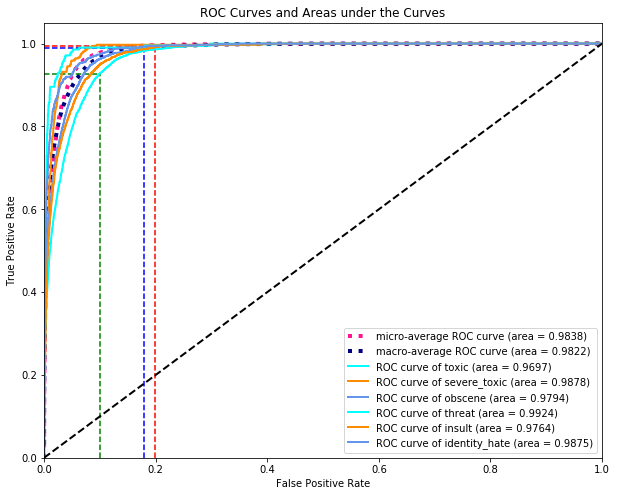

In [18]:
label_names = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
# Compute ROC curves and AUCs for test
from sklearn.metrics import roc_curve, auc
from scipy import interp

# Compute false positive rate (fpr), true positive rate (tpr) and area under the curves (rocauc)
fpr = dict()
tpr = dict()
thr = dict()
rocauc = dict()
for i in range(y_test.shape[1]):
    fpr[i], tpr[i], thr[i] = roc_curve(y_test[:, i], y_pred[:, i])
    rocauc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], thr["micro"] = roc_curve(y_test.ravel(), y_pred.ravel())
rocauc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute Macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(y_test.shape[1])]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(y_test.shape[1]):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= y_test.shape[1]

# Then interpolate all ROC curves at this points
mean_thr = np.zeros_like(all_fpr)
for i in range(y_test.shape[1]):
    mean_thr += interp(all_fpr, fpr[i], thr[i])

# Finally average it and compute AUC
mean_thr /= y_test.shape[1]

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
thr["macro"] = mean_thr
rocauc["macro"] = auc(fpr["macro"], tpr["macro"])

# to increase tpr, you also increase fpr. It is a trade off between the two.
# Business requirement determine which one is more important
# We can calculate the cutoff to garantee a minimum tpr or a maximum fpr
# We see here that to increase tpr, we need to lower threshold
# to decrease fpr, we need to increase threshold

# index of the first threshold for which the sensitivity > 0.98
idx1 = np.min(np.where(tpr["macro"] > 0.99)) 
# index of the first threshold for which the fall out < 0.20
idx2 = np.max(np.where(fpr["macro"] < 0.20)) 
# index of the first threshold for which the fall out < 0.10
idx3 = np.max(np.where(fpr[0] < 0.10)) 

print(thr["macro"][idx1])
print(thr["macro"][idx2])
print(thr[0][idx3])

# Plot all ROC curves
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import cycle

plt.figure(figsize=(10,8))
lw = 2

plt.figure(figsize=(10,8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'
               ''.format(rocauc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.4f})'
               ''.format(rocauc["macro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot([0,fpr["macro"][idx1]], [tpr["macro"][idx1],tpr["macro"][idx1]], 'k--', color='blue')
plt.plot([fpr["macro"][idx1],fpr["macro"][idx1]], [0,tpr["macro"][idx1]], 'k--', color='blue')

plt.plot([0,fpr["macro"][idx2]], [tpr["macro"][idx2],tpr["macro"][idx2]], 'k--', color='red')
plt.plot([fpr["macro"][idx2],fpr["macro"][idx2]], [0,tpr["macro"][idx2]], 'k--', color='red')

plt.plot([0,fpr[0][idx3]], [tpr[0][idx3],tpr[0][idx3]], 'k--', color='green')
plt.plot([fpr[0][idx3],fpr[0][idx3]], [0,tpr[0][idx3]], 'k--', color='green')

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(y_test.shape[1]), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of {0} (area = {1:0.4f})'
             ''.format(label_names[i], rocauc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves and Areas under the Curves')
plt.legend(loc="lower right")
plt.show()

In [19]:
# Generate a summary report for the best model architecture
best_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 200, 300)     30000000    input_3[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_3 (SpatialDro (None, 200, 300)     0           embedding_3[0][0]                
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 200, 300, 1)  0           spatial_dropout1d_3[0][0]        
__________________________________________________________________________________________________
conv2d_6 (

best params: <keras.wrappers.scikit_learn.KerasClassifier object at 0x1a7253dcc0>
best params: {'Sdroprate': 0.4, 'activation': 'tanh', 'batch_size': 256, 'droprate': 0.1, 'epochs': 5, 'filters': 32, 'k': [2, 3, 4, 5]}
best score: 0.9892973029037183


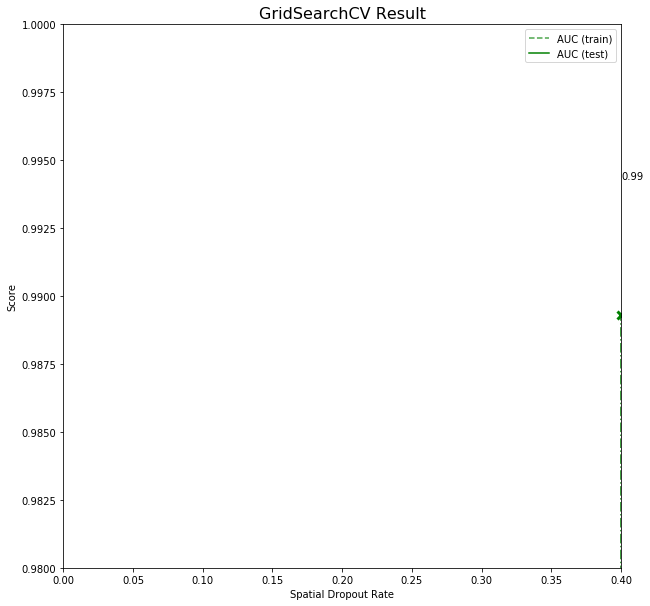

In [20]:
# Plot result of the Grid Search
%matplotlib inline
import matplotlib.pyplot as plt
results = grid_result.cv_results_

print('='*20)
print("best params: " + str(grid_result.best_estimator_))
print("best params: " + str(grid_result.best_params_))
print('best score:', grid_result.best_score_)
print('='*20)

plt.figure(figsize=(10, 10))
plt.title("GridSearchCV Result",fontsize=16)

plt.xlabel("Spatial Dropout Rate")
plt.ylabel("Score")
plt.grid()

ax = plt.axes()
ax.set_xlim(0, max(param_grid['Sdroprate']))
ax.set_ylim(0.98, 1.00)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_Sdroprate'].data, dtype=float)

for scorer, color in zip(list(scoring.keys()), ['g', 'k', 'b']): 
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]   
    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid('off')
plt.show()